In [2]:
# !pip install tslearn

In [4]:
# !pip install iisignature

In [1]:
# !git clone 'https://github.com/crispitagorico/Signature-Kernel.git'

# %cd Signature-Kernel/src/ 

# !python setup.py build_ext --inplace

In [2]:
%cd Signature-Kernel/notebooks/

/mnt/batch/tasks/shared/LS_root/mounts/clusters/nc6-k80-6-56-cs/code/Users/csalvi/Signature-Kernel/notebooks


In [368]:
import base

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import notebook as tqdm
import matplotlib.pyplot as plt
import torch 

import iisignature

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from tslearn.svm import TimeSeriesSVC

from transformers_sig import AddTime, LeadLag

from sigKer_fast import sig_kernel_Gram_matrix 
from sigKer_torch import SigKernelGramMat

In [4]:
def transform(paths, scale=1., at=False, ll=False):
    if ll:
        paths = LeadLag().fit_transform(paths)
    if at:
        paths = AddTime().fit_transform(paths)
    return scale*np.array(paths)

In [204]:
data = UCR_UEA_datasets().list_multivariate_datasets()

data_dic = {11:'FingerMovements', 
            14:'Heartbeat', 
#             15:'InsectWingbeat', 
            19: 'MotorImagery', 
            20: 'NATOPS', 
            22:'PEMS-SF'}

name = data_dic[19]

In [205]:
X_train, Y_train, X_test, Y_test = UCR_UEA_datasets(use_cache=True).load_dataset(name)

In [352]:
subsample = 10
subsample_len = 20

x_train = X_train[::subsample,::subsample_len,:]
y_train = Y_train[::subsample]
x_test = X_test[::subsample,::subsample_len,:]
y_test = Y_test[::subsample]

# x_train = TimeSeriesScalerMinMax().fit_transform(x_train)
# x_train = TimeSeriesScalerMeanVariance().fit_transform(x_train)
# x_test = TimeSeriesScalerMinMax().fit_transform(x_test)
# x_test = TimeSeriesScalerMeanVariance().fit_transform(x_test)

print(x_train.shape)
print(x_test.shape)

(28, 150, 64)
(10, 150, 64)


In [353]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

In [354]:
scale = 1e-2
at = False
ll = False

In [355]:
x_train = transform(x_train, scale, at, ll)
x_test = transform(x_test, scale, at, ll)

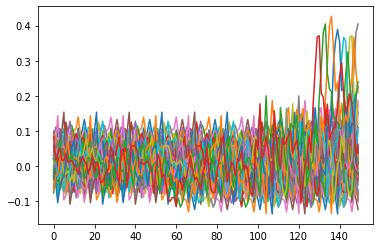

In [356]:
plt.plot(x_train[5])
plt.show()

In [357]:
print(f'classes: {np.unique(y_train)}')

classes: [0 1]


In [433]:
n, solver =  3, 1

In [434]:
# x_train_ = torch.tensor(x_train).cuda()
# x_test_ = torch.tensor(x_test).cuda()

In [435]:
gram_matrix = sig_kernel_Gram_matrix(x_train, x_train, n, solver, sym=True)
# gram_matrix_ = SigKernelGramMat.apply(x_train_, x_train_, n, solver, True)

In [436]:
test_matrix = sig_kernel_Gram_matrix(x_train, x_test, n, solver, sym=False)
# test_matrix_ = SigKernelGramMat.apply(x_train_, x_test_, n, solver, False)

In [427]:
# gram_matrix = gram_matrix_.cpu().numpy()
# test_matrix = test_matrix_.cpu().numpy()

In [437]:
svc_parameters = {'C': np.logspace(-1, 5, 7), 'gamma': np.logspace(-5, 5, 11)}

In [438]:
svc = TimeSeriesSVC(kernel='precomputed', decision_function_shape='ovo')

svc_model = GridSearchCV(estimator=svc, 
                         param_grid=svc_parameters, 
                         cv=TimeSeriesSplit(n_splits=5),
                         n_jobs=-1)

In [439]:
svc_model.fit(gram_matrix, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=TimeSeriesSVC(decision_function_shape='ovo',
                                     kernel='precomputed'),
             n_jobs=-1,
             param_grid={'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
                         'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])})

In [440]:
predictions = svc_model.predict(test_matrix.T)

In [441]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.50      1.00      0.67         3

    accuracy                           0.70        10
   macro avg       0.75      0.79      0.70        10
weighted avg       0.85      0.70      0.71        10



In [447]:
final = {}

In [448]:
final['sig-ker-PDE'] = svc_model.score(test_matrix.T, y_test)

ValueError: Dimensions of the provided timeseries(except first) must match those of the fitted data! ((28, 4160, 1) and (10, 28, 1) are passed shapes)

In [449]:
for ker in tqdm.tqdm(['linear', 'rbf', 
                      'gak'
                     ]):
    
    svc = TimeSeriesSVC(kernel=ker, decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)
    
    svc_model.fit(x_train, y_train)
    
    final[ker] = svc_model.score(x_test, y_test)

In [450]:
# truncated signature kernel
for d in tqdm.tqdm(range(1,3)):
    
    svc = TimeSeriesSVC(kernel='linear', decision_function_shape='ovo')

    svc_model = GridSearchCV(estimator=svc, 
                             param_grid=svc_parameters, 
                             cv=TimeSeriesSplit(n_splits=5),
                             n_jobs=-1)

    sig_train = [iisignature.sig(path, d) for path in x_train]
    sig_test = [iisignature.sig(path, d) for path in x_test]

    svc_model.fit(sig_train, y_train)

    final[f'sig-ker-{d}'] = svc_model.score(sig_test, y_test)

In [451]:
final_csv = pd.DataFrame.from_dict(final, orient='index').rename(columns={0:'accuracy (%)'})
print(final_csv)
final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}.csv')

           accuracy (%)
linear              0.4
rbf                 0.4
gak                 0.3
sig-ker-1           0.4
sig-ker-2           0.5
